# Vision Transformer

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set up paths
train_path = "F:/Brain Tumor Detection/Contour and Region based/Training"
batch_size = 32
image_size = (224, 224)  # ViT models typically use 224x224 image size

# Data loading and preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42
)

# Normalizing the data
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Define the Vision Transformer model
class VisionTransformer(tf.keras.Model):
    def __init__(self, num_classes=1, patch_size=16, num_layers=12, num_heads=8, embed_dim=64, mlp_dim=128, image_size=224):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.projection = layers.Dense(embed_dim)
        
        # Positional encoding layer
        self.positional_encoding = layers.Embedding(input_dim=self.num_patches, output_dim=embed_dim)
        
        # Define transformer layers
        self.transformer_layers = [
            layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads) for _ in range(num_layers)
        ]
        
        # Define MLP head for classification
        self.mlp_head = models.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dense(num_classes, activation="sigmoid")
        ])
    
    def call(self, x):
        # Convert image to patches
        batch_size = tf.shape(x)[0]
        patch_dim = self.patch_size * self.patch_size * 3
        x = tf.image.extract_patches(
            images=x,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        x = tf.reshape(x, [batch_size, self.num_patches, patch_dim])
        
        # Project patches to embedding space
        x = self.projection(x)
        
        # Add positional encoding
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        x += self.positional_encoding(positions)
        
        # Transformer layers with residual connections
        for transformer in self.transformer_layers:
            x = transformer(x, x) + x  # Apply self-attention and residual connection
        
        # Pooling layer to aggregate features
        x = tf.reduce_mean(x, axis=1)
        
        # MLP head for final output
        return self.mlp_head(x)

# Instantiate and compile the model
model = VisionTransformer()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train_ds,
    epochs=20
)


Found 2872 files belonging to 2 classes.
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 67s 570ms/step - accuracy: 0.6022 - loss: 0.6757
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 579ms/step - accuracy: 0.6111 - loss: 0.6596
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 573ms/step - accuracy: 0.7159 - loss: 0.5720
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 576ms/step - accuracy: 0.7678 - loss: 0.5071
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 51s 563ms/step - accuracy: 0.8032 - loss: 0.4382
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 550ms/step - accuracy: 0.8328 - loss: 0.3835
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 552ms/step - accuracy: 0.8524 - loss: 0.3505
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 557ms/step - accuracy: 0.8542 - loss: 0.3402
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 555ms/step - accuracy: 0.8801 - loss: 0.2901
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 556ms/step - accuracy: 0.8900 - loss: 0.2589
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 574ms/step - accuracy: 0.9010 - loss: 0.2324


In [11]:
import tensorflow as tf

# Set up the testing data path
test_path = "F:/Brain Tumor Detection/Contour and Region based/Testing"
batch_size = 32
image_size = (224, 224)  # Image size must match the training image size

# Load and preprocess the testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)

# Normalize the testing data
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Found 1064 files belonging to 2 classes.
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.8883 - loss: 0.2566
Test Loss: 0.2170
Test Accuracy: 0.9098


Found 1064 files belonging to 2 classes.
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step
Classification Report:
{'Non-Tumor': {'precision': 0.9422680412371134, 'recall': 0.8704761904761905, 'f1-score': 0.904950495049505, 'support': 525.0}, 'Tumor': {'precision': 0.8825561312607945, 'recall': 0.948051948051948, 'f1-score': 0.9141323792486583, 'support': 539.0}, 'accuracy': 0.9097744360902256, 'macro avg': {'precision': 0.912412086248954, 'recall': 0.9092640692640692, 'f1-score': 0.9095414371490816, 'support': 1064.0}, 'weighted avg': {'precision': 0.9120192447359518, 'recall': 0.9097744360902256, 'f1-score': 0.9096018442819708, 'support': 1064.0}}
              precision    recall  f1-score      support
Non-Tumor      0.942268  0.870476  0.904950   525.000000
Tumor          0.882556  0.948052  0.914132   539.000000
accuracy       0.909774  0.909774  0.909774     0.909774
macro avg      0.912412  0.909264  0.909541  1064.000000
weighted avg   0.912019  0.909774  0.909602  1064.000000


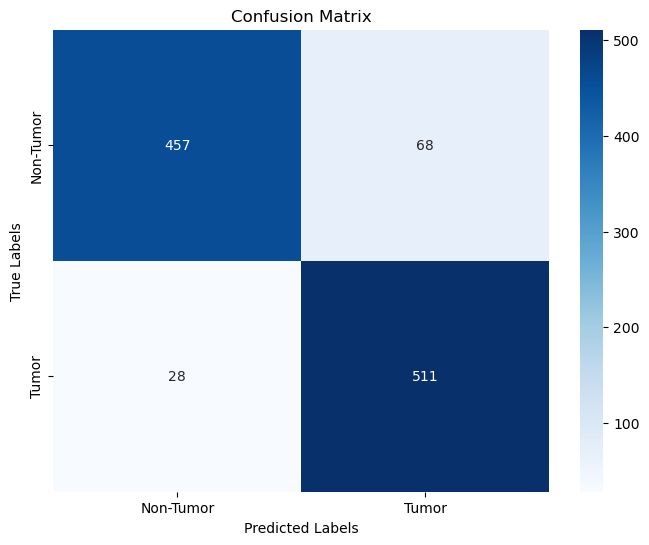

In [13]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the testing data path
test_path = "F:/Brain Tumor Detection/Contour and Region based/Testing"
batch_size = 32
image_size = (224, 224)

# Load and preprocess the testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)

# Normalize the testing data
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Get ground truth labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary labels (0 or 1)

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['Non-Tumor', 'Tumor'], output_dict=True)
print("Classification Report:")
print(report)

# Display the report as a table
import pandas as pd
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Tumor', 'Tumor'], yticklabels=['Non-Tumor', 'Tumor'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [14]:
model.save('VisionTransformer.h5')